In [12]:
# Startup databrokers and elastic search
from pprint import pprint

from rapidz.graph import _clean_text, readable_graph
from xpdan.vend.callbacks.core import Retrieve
from xpdan.vend.callbacks.zmq import Publisher
from xpdconf.conf import glbl_dict

from databroker_elasticsearch import load_elasticindex
from databroker_elasticsearch.brokersearch import BrokerSearch

from databroker import Broker
import yaml



def filtertype(seq, tp):
    return (o for o in seq if isinstance(o, tp))


@register_converter
def tomo_usednodes(graph):
    nodes = []
    fmt = '{mod}.{name}'
    for n in graph['nodes']:
        st = n['stream']
        e = dict()
        e['ndtype'] = fmt.format(**st)
        ad = next(filtertype(st['args'], dict), None)
        al = next(filtertype(st['args'], list), None)
        if ad is not None:
            e['ndfunc'] = fmt.format(**ad)
        elif al is not None:
            e['ndfunc'] = next(filtertype(al, str))
        nodes.append(e)
    return nodes
        
dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))
from databroker_elasticsearch.converters import register_converter

an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)

In [18]:
# query raw es for dino tooth
raw_es.qsearch()
vqraw = lambda q: pprint((q, raw_es.qsearch(q)))
vqraw('tooth')  # search all fields
vqraw('dinosaur')  # search all fields
vqraw('sample_name:dinosaur')  # search specific field
vqraw('dino*')  # glob-like search
vqraw('dinosaurus~2')  # fuzzy search max edit distance of 2
vqraw('/saur/')  # regular expression search
raw_hdr = next(iter(raw_db_es('dinosaurus~2')))
uid = raw_hdr.start['uid']

('tooth',
 {'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
  'hits': {'hits': [{'_id': 'cb2ccbe9-6eb9-46bb-9d9d-ad1d07fb7529',
                     '_index': 'demo-raw',
                     '_score': 0.2876821,
                     '_source': {'date': '2019-04-11T10:44:15.488',
                                 'detectors': ['img'],
                                 'num_points': 16,
                                 'plan_name': 'list_scan',
                                 'sample_name': 'sabertooth tiger tooth',
                                 'scan_id': 1,
                                 'time': 1554993855.4878254,
                                 'uid': 'cb2ccbe9-6eb9-46bb-9d9d-ad1d07fb7529'},
                     '_type': 'run_start'},
                    {'_id': '0fff0fa8-7515-48d6-806c-7773b9207976',
                     '_index': 'demo-raw',
                     '_score': 0.2876821,
                     '_source': {'date': '2019-04-11T10:46:12.830',
     

In [40]:
# queries with an_es
vqan = lambda q: pprint((q, an_es.qsearch(q)))
vqan('img_sinogram')
vqan(f'puid:{uid[:6]}*')  # word in puid
vqan('analysis_stage:img_sinogram')
vqan('usednodes.ndfunc:*sort_sinogram')

# query an_es/databroker for tomo recon
hdrs = an_db_es('analysis_stage:*tomo*')
tomo_analysis_hdr = next(iter(hdrs))
print(tomo_analysis_hdr.start['analysis_stage'])

('img_sinogram',
 {'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
  'hits': {'hits': [{'_id': '77d59740-6015-48f7-a8e0-1c3d48249831',
                     '_index': 'demo-an',
                     '_score': 0.6931472,
                     '_source': {'analysis_stage': 'img_sinogram',
                                 'puid': ['9a7ebf46-3baf-438e-a12e-60a0f7955dee'],
                                 'uid': '77d59740-6015-48f7-a8e0-1c3d48249831',
                                 'usednodes': [{'ndtype': 'shed.translation.ToEventStream'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.conditional_squeeze',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.sort_sinogram',
                                                'ndtype': 'rapidz.core.starmap'},
                                               {'ndfunc': 'xpdtools.pipel

                                                'ndtype': 'rapidz.core.starmap'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.flatten',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndtype': 'rapidz.core.combine_latest'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.append_data',
                                                'ndtype': 'rapidz.core.accumulate'},
                                               {'ndtype': 'rapidz.core.zip'},
                                               {'ndfunc': 'tomopy.prep.normalize.minus_log',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.reshape',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndtype'

                                               {'ndtype': 'rapidz.core.zip'},
                                               {'ndfunc': 'tomopy.prep.normalize.minus_log',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.reshape',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndtype': 'shed.translation.FromEventStream'},
                                               {'ndfunc': 'numpy.deg2rad',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndtype': 'shed.translation.FromEventStream'}]},
                     '_type': 'run_start'},
                    {'_id': 'be44cac8-fc48-4f4a-a538-bbbe2ce6b7f7',
                     '_index': 'demo-an',
                     '_score': 0.35667494,
                     '_source': {'anal

                                               {'ndtype': 'shed.translation.FromEventStream'}]},
                     '_type': 'run_start'},
                    {'_id': '77d59740-6015-48f7-a8e0-1c3d48249831',
                     '_index': 'demo-an',
                     '_score': 1.0,
                     '_source': {'analysis_stage': 'img_sinogram',
                                 'puid': ['9a7ebf46-3baf-438e-a12e-60a0f7955dee'],
                                 'uid': '77d59740-6015-48f7-a8e0-1c3d48249831',
                                 'usednodes': [{'ndtype': 'shed.translation.ToEventStream'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.conditional_squeeze',
                                                'ndtype': 'rapidz.core.map'},
                                               {'ndfunc': 'xpdtools.pipelines.tomo.sort_sinogram',
                                                'ndtype': 'rapidz.core.starmap'},
                          

/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
DELETE http://localhost:9200/_search/scroll [status:N/A request:0.000s]
Traceback (most recent call last):
  File "/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/elasticsearch/helpers/__init__.py", line 382, in scan
    yield hit
GeneratorExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/elasticsearch/connection/http_urllib3.py", line 172, in perform_request
    response = self.pool.urlopen(method, url, body, retries=Retry(False), headers=request_headers, **kw)
  File "/home/christopher/mc/envs/dp_dev/lib/python3.6/site-packages/urllib3/connectionpool.py", line 588, in urlopen
    conn = self._g

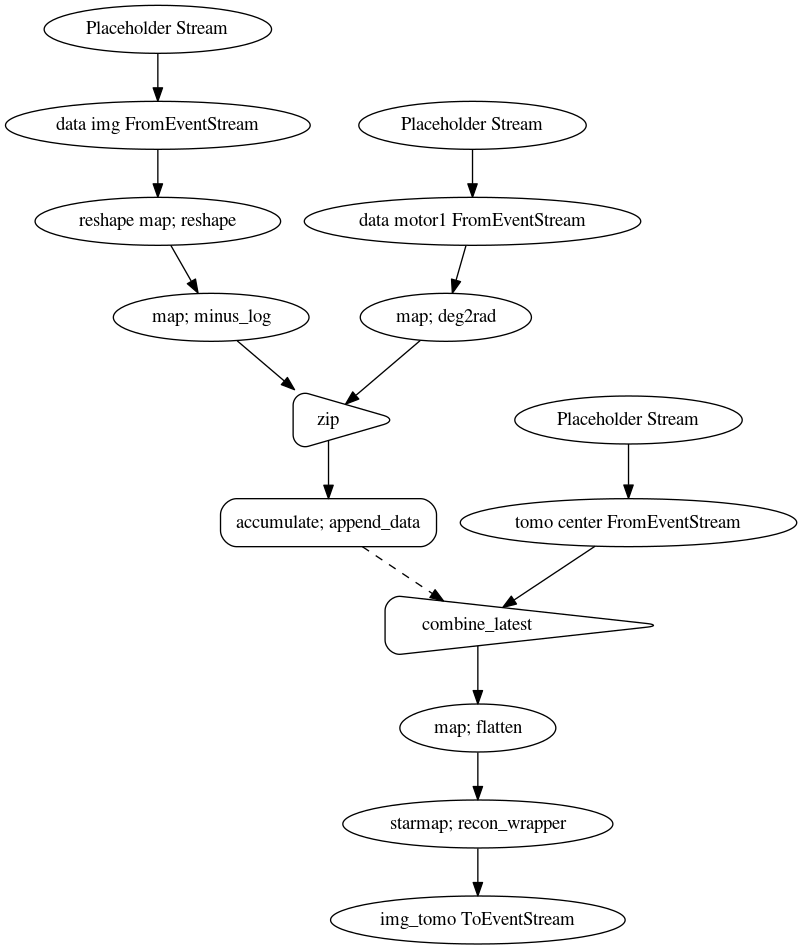

In [41]:
# show the graph
from shed.replay import replay

# load the replay
graph, parents, data, vs = replay(raw_db, tomo_analysis_hdr)

# make the graph more accessible to humans by renaming things
# these names *should* match the names in the graph plot
for k, v in graph.nodes.items():
    v.update(label=_clean_text(str(v['stream'])).strip())
graph = readable_graph(graph)

# plot the graph
graph.nodes['data img FromEventStream']['stream'].visualize()

In [42]:
# setup a publisher to send over to data viz and capture
p = Publisher(glbl_dict['inbound_proxy_address'], prefix=b'tomo')
graph.nodes['img_tomo ToEventStream']['stream'].DBFriendly().starsink(p)

# replay analysis with no changes
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

{'algorithm': 'gridrec'}


In [56]:
# change to Algebra
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)
graph.nodes['starmap; recon_wrapper']['stream'].kwargs['algorithm'] = 'art'
print(graph.nodes['starmap; recon_wrapper']['stream'].kwargs)

# replay with changes
r = Retrieve(dbs['raw'].reg.handler_reg)
for v in vs:
    d = data[v['uid']]
    dd = r(*d)
    parents[v["node"]].update(dd)

{'algorithm': 'art'}
{'algorithm': 'art'}


In [ ]:
# Compare results

# Needs to have an independent stream for final data

In [55]:
dbs = {}
for yaml_file in ['raw', 'an']:
    with open(f'{yaml_file}.yml', 'r') as f:
        dbs[yaml_file] = Broker.from_config(yaml.load(f))
from databroker_elasticsearch.converters import register_converter

an_db = dbs['an']
raw_db = dbs['raw']
raw_es = load_elasticindex('es-raw.yaml')
an_es = load_elasticindex('es-an.yaml')
raw_db_es = BrokerSearch(raw_db, raw_es)
an_db_es = BrokerSearch(an_db, an_es)

# an_es for new data (via new recon algo)
# vqan('*')
pprint(an_db[-1].start['graph'])

{'directed': True,
 'graph': {},
 'links': [{'source': 8730265731062,
            'target': '322e369c-30ed-4be3-8447-9b3afaf54b81'},
           {'source': 8730265731048, 'target': 8730265731062},
           {'source': 8730265731034, 'target': 8730265731048},
           {'source': -9223363306589044785, 'target': 8730265731034},
           {'source': -9223363306560427313, 'target': -9223363306589044785},
           {'source': -9223363306560432359, 'target': -9223363306560427313},
           {'source': -9223363306560432345, 'target': -9223363306560432359},
           {'source': '274d8461-3694-4013-8e18-84e15a35bf8e',
            'target': -9223363306560432345},
           {'source': 8730294343495, 'target': -9223363306560427313},
           {'source': 'd772a970-b4c5-4ff0-99bf-f68c2647adf4',
            'target': 8730294343495},
           {'source': '6af9b684-0ba6-40b7-88c7-80f73c4f7bad',
            'target': 8730265731034}],
 'multigraph': False,
 'nodes': [{'id': '322e369c-30ed-4be3-84

In [53]:
import json
with open('start.json', 'w') as f:
    json.dump(an_db[-2].start, f)